In [1]:
import pyvisa
import datetime
import json
import time
import numpy as np
import matplotlib.pyplot as plt

In [581]:
# Connect to keithleys
rm = pyvisa.ResourceManager()
print(rm.list_resources())

emitter = rm.open_resource('GPIB1::10::INSTR')
extractor = rm.open_resource('GPIB1::11::INSTR')
gate = rm.open_resource('GPIB1::9::INSTR')

print("Using " + emitter.query('*IDN?'))
print("Using " + extractor.query('*IDN?'))
print("Using " + gate.query('*IDN?'))

('TCPIP0::18.25.29.125::inst0::INSTR', 'TCPIP0::K-CX3300-ERIAL.local::hislip0::INSTR', 'TCPIP0::K-CX3300-ERIAL.local::inst0::INSTR', 'ASRL1::INSTR', 'ASRL4::INSTR', 'GPIB1::9::INSTR', 'GPIB1::10::INSTR', 'GPIB1::11::INSTR')
Using Keithley Instruments Inc., Model 2657A, 1409197, 1.2.0

Using Keithley Instruments Inc., Model 2657A, 4033749, 1.1.8

Using Keithley Instruments Inc., Model 2657A, 1409200, 1.1.8



In [582]:
emitter.write('smua.reset()')
extractor.write('smua.reset()')
gate.write('smua.reset()')

14

In [623]:
# experiment_name = 'test'
data_dir = 'C://Users//kashkin//Desktop//keithley data//'
current_limit = .5e-3
notes = '1e-7 torr'
total_time = 30
voltage_limit = 3.2e3
set_voltage = -1000
gate_set_voltage = 100
measurement_count = 1
filter_measurement_count = 5
experiment_name = '{time} s tuball 631e mozzarella {voltage} v emitter {gate} v gate'.format(time=total_time,voltage=set_voltage, gate=gate_set_voltage)
nplc = 1 # nplc/60 is the period of the measurement


In [624]:
# Configure as voltage source
emitter.write(' \
    smua.source.func = smua.OUTPUT_DCVOLTS \n\
    display.smua.measure.func = display.MEASURE_DCAMPS \n\
    smua.measure.autozero = smua.AUTOZERO_AUTO \n\
    smua.measure.autorangei = smua.AUTORANGE_OFF \n\
    smua.measure.rangei = {i_lim} \n\
    smua.measure.rangev = {v_lim} \n\
    smua.source.limiti = {i_lim} \n\
    smua.measure.adc = smua.ADC_INTEGRATE \n\
    smua.measure.nplc = {nplc} \n\
    smua.measure.delay = smua.DELAY_OFF \n\
    smua.measure.count = {m_count} \n\
    smua.measure.filter.count = {f_count} \n\
    smua.measure.filter.enable = smua.FILTER_ON \n\
    smua.measure.filter.type = smua.FILTER_REPEAT_AVG \
    '.format(i_lim = current_limit, v_lim = voltage_limit, m_count = measurement_count, nplc=nplc, f_count = filter_measurement_count))

583

In [625]:
# Configure as voltage source
extractor.write(' \
    smua.source.func = smua.OUTPUT_DCVOLTS \n\
    display.smua.measure.func = display.MEASURE_DCAMPS \n\
    smua.measure.autozero = smua.AUTOZERO_AUTO \n\
    smua.measure.autorangei = smua.AUTORANGE_OFF \n\
    smua.measure.rangei = {i_lim} \n\
    smua.measure.rangev = {v_lim} \n\
    smua.source.limiti = {i_lim} \n\
    smua.measure.adc = smua.ADC_INTEGRATE \n\
    smua.measure.nplc = {nplc} \n\
    smua.measure.delay = smua.DELAY_OFF \n\
    smua.measure.count = {m_count} \n\
    smua.measure.filter.count = {f_count} \n\
    smua.measure.filter.enable = smua.FILTER_ON \n\
    smua.measure.filter.type = smua.FILTER_REPEAT_AVG \
    '.format(i_lim = current_limit, v_lim = voltage_limit, m_count = measurement_count, nplc=nplc, f_count = filter_measurement_count))

583

In [626]:
# Configure as voltage source
gate.write(' \
    smua.source.func = smua.OUTPUT_DCVOLTS \n\
    display.smua.measure.func = display.MEASURE_DCAMPS \n\
    smua.measure.autozero = smua.AUTOZERO_AUTO \n\
    smua.measure.autorangei = smua.AUTORANGE_OFF \n\
    smua.measure.rangei = {i_lim} \n\
    smua.measure.rangev = {v_lim} \n\
    smua.source.limiti = {i_lim} \n\
    smua.measure.adc = smua.ADC_INTEGRATE \n\
    smua.measure.nplc = {nplc} \n\
    smua.measure.delay = smua.DELAY_OFF \n\
    smua.measure.count = {m_count} \n\
    smua.measure.filter.count = {f_count} \n\
    smua.measure.filter.enable = smua.FILTER_ON \n\
    smua.measure.filter.type = smua.FILTER_REPEAT_AVG \
    '.format(i_lim = current_limit, v_lim = voltage_limit, m_count = measurement_count, nplc=nplc, f_count = filter_measurement_count))

583

In [627]:
aggregate_data = {'notes':notes,'voltage':set_voltage,'measured_emitter_voltages':[],'measured_gate_voltages':[],'measured_extractor_voltages':[],'emitter_currents':[],'extractor_currents':[],'gate_currents':[],'times':[]}


In [628]:
# Conduct iteration of voltages applied to emitter with extractor set as ground
start_time = float(datetime.datetime.now().timestamp())
elapsed_time = 0

emitter.write('smua.source.levelv = %s'%set_voltage)
extractor.write('smua.source.levelv = 0')
gate.write('smua.source.levelv = %s'%gate_set_voltage)

while elapsed_time < total_time:
        emitter.write('ireading, vreading = smua.measure.iv(smua.nvbuffer1, smua.nvbuffer2)')
        extractor.write('ireading, vreading = smua.measure.iv(smua.nvbuffer1, smua.nvbuffer2)')
        gate.write('ireading, vreading = smua.measure.iv(smua.nvbuffer1, smua.nvbuffer2)')

        emitter_current = float(emitter.query("print(ireading)")[:-1])
        emitter_voltage = float(emitter.query("print(vreading)")[:-1])

        extractor_current = float(extractor.query("print(ireading)")[:-1])
        extractor_voltage = float(extractor.query("print(vreading)")[:-1])

        gate_current = float(gate.query("print(ireading)")[:-1])
        gate_voltage = float(gate.query("print(vreading)")[:-1])

        aggregate_data['measured_emitter_voltages'].append(emitter_voltage)
        aggregate_data['measured_extractor_voltages'].append(extractor_voltage)
        aggregate_data['measured_gate_voltages'].append(gate_voltage)

        aggregate_data['emitter_currents'].append(emitter_current)
        aggregate_data['extractor_currents'].append(extractor_current)
        aggregate_data['gate_currents'].append(gate_current)

        aggregate_data['times'].append(elapsed_time)

        elapsed_time = float(datetime.datetime.now().timestamp()) - start_time

emitter.write('smua.source.levelv = 0')
extractor.write('smua.source.levelv = 0')
gate.write('smua.source.levelv = 0')


24

In [629]:
# dts = []
# for i in range(len(aggregate_data['times']) - 1):
#     dts.append(aggregate_data['times'][i+1] - aggregate_data['times'][i])
# print(np.average(dts))
# print(1/np.average(dts))

In [630]:
# plt.hist(dts)
# plt.show()

In [631]:
filename = data_dir + experiment_name + '_ %s'%datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S') + '.json'

with open(filename, 'w') as file:
    json.dump(aggregate_data, file)

print('saved to %s' %{filename})

saved to {'C://Users//kashkin//Desktop//keithley data//30 s tuball 631e mozzarella -1000 v emitter 100 v gate_ 2022_11_21-17_46_53.json'}


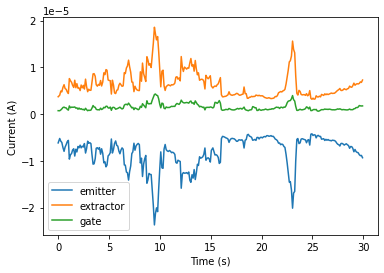

In [632]:
plt.plot(aggregate_data['times'],aggregate_data['emitter_currents'],label='emitter')
plt.plot(aggregate_data['times'],aggregate_data['extractor_currents'],label='extractor')
plt.plot(aggregate_data['times'],aggregate_data['gate_currents'],label='gate')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
# plt.ylim(-5e-5,5e-5)
# plt.ylim(-current_limit,current_limit)
plt.legend()
plt.show()

In [580]:
#Turn off output and drain capacitors
print("\nSetting source voltage to 0 V")
emitter.write("smua.source.levelv = 0")
extractor.write("smua.source.levelv = 0")

print("Turning off output")
emitter.write("smua.source.output = 0")
extractor.write("smua.source.output = 0")

print("Closing Keithley connection")
emitter.close()
extractor.close()


Setting source voltage to 0 V
Turning off output
Closing Keithley connection
